# Numerical stability filter
> experiment with numerical stability filter

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from fastcore.test import *
from fastcore.basics import *
from meteo_imp.utils import *
from meteo_imp.gaussian import *
from meteo_imp.kalman.filter import *
from meteo_imp.kalman.filter import get_test_data
from meteo_imp.kalman.fastai import *
from fastcore.transform import *
from fastcore.foundation import *
from fastcore.basics import *
from fastai.data.core import *
from itertools import *

import numpy as np
import pandas as pd
import torch
from torch import Tensor
from torch.distributions import MultivariateNormal

In [ ]:
reset_seed()

In [ ]:
n_dim_obs = 5
n_dim_state = 5
n_dim_contr = 3
dtype=torch.float64
bs = 2
n_obs= 10

In [ ]:
a_gap = AddGapTransform(variables = [0, 1], gap_length = 5)

In [ ]:
data = torch.rand(n_obs, n_dim_obs, dtype=dtype)
control = torch.rand(n_obs, n_dim_contr, dtype=dtype)

In [ ]:
dc = DataControl(pd.DataFrame(data), pd.DataFrame(control))

In [ ]:
class RandomDataControl(Transform):
    def __init__(self, n_obs, n_dim_obs, n_dim_contr, dtype): store_attr()
    def encodes(self, _):
        data = np.random.normal(size=(self.n_obs, self.n_dim_obs)).astype(dtype=self.dtype)
        control = np.random.normal(size=(self.n_obs, self.n_dim_contr)).astype(dtype=self.dtype)
        return DataControl(pd.DataFrame(data), pd.DataFrame(control)) 

In [ ]:
a_gap(dc)

,0,1,2,3,4
0,0.8775,0.2675,0.0937,0.6706,0.1638
1,0.9272,0.2620,0.4967,0.2630,0.1175
2,0.1694,0.2100,0.4890,0.0564,0.4760
3,0.7606,0.7759,0.5243,0.3714,0.0426
4,0.2343,0.9991,0.1775,0.6319,0.6734
5,0.7937,0.6468,0.5825,0.4599,0.7960
6,0.9038,0.9735,0.6428,0.3725,0.2052
7,0.0507,0.4448,0.5775,0.7237,0.5927
8,0.3217,0.6441,0.2801,0.9132,0.0329
9,0.4856,0.9927,0.5895,0.2611,0.9413


In [ ]:
test_dls = TfmdLists([1,2], [RandomDataControl(100, n_dim_obs, n_dim_contr, dtype=np.float32), AddGapTransform(variables = [0, 1], gap_length = 5), MeteoImpDf2Tensor, ToTuple]).dataloaders(bs=bs)

In [ ]:
covchecker = CheckPosDef(do_check=True)

In [ ]:
k = KalmanFilter.init_random(n_dim_obs,n_dim_state, n_dim_contr, dtype=torch.float32, cov_checker=covchecker).cuda()
(data, mask, control), _ = test_dls.one_batch()

In [ ]:
k.obs_cov.dtype

torch.float32

In [ ]:
k.predict(data, mask, control);

In [ ]:
covchecker.log.is_pd_eigv.all()

True

In [ ]:
def filter_posdef(n_dim_obs = 5,
                n_dim_state = 5,
                n_dim_contr = 3,
                dtype=torch.float32,
                bs = 2,
                n_obs= 10,
                gap_len = 5,
                n_missing = 3,
                warn=True,):
    
    test_dls = TfmdLists(list(range(bs)), [RandomDataControl(n_obs, n_dim_obs, n_dim_contr, dtype=np.float32),
                                 AddGapTransform(variables = list(range(n_missing)), gap_length = gap_len),
                                 MeteoImpDf2Tensor,
                                 ToTuple]).dataloaders(bs=bs)
    covchecker = CheckPosDef(do_check=True, warning=warn)
    k = KalmanFilter.init_random(n_dim_obs,n_dim_state, n_dim_contr, dtype=torch.float32, cov_checker=covchecker).cuda()
    (data, mask, control), _ = test_dls.one_batch()
    k.predict(data, mask, control)
    return covchecker

In [ ]:
cc1 = filter_posdef(n_dim_obs = 3,
              n_dim_state = 6,
              n_dim_contr = 6,
              n_obs = 200)

/home/simone/Documents/uni/Thesis/GPFA_imputation/meteo_imp/gaussian.py:134: UserWarning: Matrix is not positive definite
  warn("Matrix is not positive definite")
/home/simone/Documents/uni/Thesis/GPFA_imputation/meteo_imp/gaussian.py:134: UserWarning: Matrix is not positive definite
  warn("Matrix is not positive definite")
/home/simone/Documents/uni/Thesis/GPFA_imputation/meteo_imp/gaussian.py:134: UserWarning: Matrix is not positive definite
  warn("Matrix is not positive definite")
/home/simone/Documents/uni/Thesis/GPFA_imputation/meteo_imp/gaussian.py:134: UserWarning: Matrix is not positive definite
  warn("Matrix is not positive definite")
/home/simone/Documents/uni/Thesis/GPFA_imputation/meteo_imp/gaussian.py:134: UserWarning: Matrix is not positive definite
  warn("Matrix is not positive definite")
/home/simone/Documents/uni/Thesis/GPFA_imputation/meteo_imp/gaussian.py:134: UserWarning: Matrix is not positive definite
  warn("Matrix is not positive definite")
/home/simone/Doc

In [ ]:
cc1.log[cc1.log.is_pd_eigv==False]

,is_pd_eigv,is_pd_chol,is_sym,sym_upto,eigv,matrix,batch_n,caller,t
0,False,False,False,2,"[-9705.221, -254.14473, -125.49975, -35.511173, -11.8572645, 1806.5648]","[[-1780.8748, -1471.1149, -1788.3911, -1118.2871, -1638.6616, -953.68475], [-1386.2334, -1144.1714, -1391.1935, -869.865, -1274.8463, -741.8759], [-1414.5665, -1167.5818, -1419.1956, -887.52435, -1300.9683, -756.9424], [-857.4555, -707.6866, -860.40735, -537.65607, -788.43384, -458.82437], [-2952.4985, -2438.4504, -2964.4126, -1853.7776, -2715.5427, -1580.9586], [-1360.5197, -1123.469, -1365.7471, -854.0993, -1251.5979, -728.22925]]",1,filter_predict,142.0
0,False,False,False,2,"[-9705.221, -254.14473, -125.49975, -35.511173, -11.8572645, 1806.5648]","[[-1780.8748, -1471.1149, -1788.3911, -1118.2871, -1638.6616, -953.68475], [-1386.2334, -1144.1714, -1391.1935, -869.865, -1274.8463, -741.8759], [-1414.5665, -1167.5818, -1419.1956, -887.52435, -1300.9683, -756.9424], [-857.4555, -707.6866, -860.40735, -537.65607, -788.43384, -458.82437], [-2952.4985, -2438.4504, -2964.4126, -1853.7776, -2715.5427, -1580.9586], [-1360.5197, -1123.469, -1365.7471, -854.0993, -1251.5979, -728.22925]]",1,filter_correct,142.0
0,False,False,False,1,"[-1.7772285, 0.019798007, 0.20209609, 0.47303057, 1.4783517, 6.8120894]","[[0.5849339, 0.6348636, 0.5912848, 0.81322575, 0.6255918, 0.47391278], [0.112971246, 1.1613946, 1.0122957, 1.0277878, 0.85927, 0.65938085], [0.26790667, 1.2354136, 1.5670784, 1.2722743, 0.9689495, 0.836161], [1.9478744, 2.2667465, 2.583002, 2.2211912, 2.3964665, 1.4636905], [-0.12865692, 0.8796502, 0.66368175, 0.8447906, 1.12381, 0.4141515], [0.090194225, 0.6964965, 0.70974237, 0.611339, 0.39217177, 0.54972875]]",1,filter_predict,143.0
0,False,False,False,1,"[-1.7772285, 0.019798007, 0.20209609, 0.47303057, 1.4783517, 6.8120894]","[[0.5849339, 0.6348636, 0.5912848, 0.81322575, 0.6255918, 0.47391278], [0.112971246, 1.1613946, 1.0122957, 1.0277878, 0.85927, 0.65938085], [0.26790667, 1.2354136, 1.5670784, 1.2722743, 0.9689495, 0.836161], [1.9478744, 2.2667465, 2.583002, 2.2211912, 2.3964665, 1.4636905], [-0.12865692, 0.8796502, 0.66368175, 0.8447906, 1.12381, 0.4141515], [0.090194225, 0.6964965, 0.70974237, 0.611339, 0.39217177, 0.54972875]]",1,filter_correct,143.0
0,False,False,False,2,"[-1882.7568, -491.04315, -182.91718, 3.9417417, 398.4144, 922.90314]","[[-12.290682, -9.900223, -12.236867, -7.2878118, -11.25538, -6.3927917], [-633.5527, -522.3006, -635.29034, -397.03897, -582.2503, -338.7248], [-258.11017, -212.11041, -257.78928, -161.05289, -236.82793, -137.52026], [343.14542, 284.25763, 345.33304, 216.54553, 316.32654, 184.2425], [-529.8437, -436.83832, -531.387, -331.901, -486.27527, -283.3312], [-317.09424, -261.38446, -317.85522, -198.63419, -291.46417, -169.34784]]",0,filter_predict,172.0
0,False,False,False,2,"[-1882.7568, -491.04315, -182.91718, 3.9417417, 398.4144, 922.90314]","[[-12.290682, -9.900223, -12.236867, -7.2878118, -11.25538, -6.3927917], [-633.5527, -522.3006, -635.29034, -397.03897, -582.2503, -338.7248], [-258.11017, -212.11041, -257.78928, -161.05289, -236.82793, -137.52026], [343.14542, 284.25763, 345.33304, 216.54553, 316.32654, 184.2425], [-529.8437, -436.83832, -531.387, -331.901, -486.27527, -283.3312], [-317.09424, -261.38446, -317.85522, -198.63419, -291.46417, -169.34784]]",0,filter_correct,172.0
0,False,False,False,0,"[-0.7691803, 0.18814883, 0.3020723, 0.3087685, 0.9482941, 9.368287]","[[1.366447, 1.0066767, 1.10035, 1.3469853, 1.4241366, 0.8064898], [1.2871498, 2.0487084, 2.1081161, 1.7782356, 1.9636576, 1.2623723], [1.487232, 1.9691564, 2.5159297, 2.0810776, 2.1707358, 1.4035099], [1.1819317, 1.6691704, 1.8495765, 1.734071, 1.6800221, 1.0641345], [0.7733191, 2.3484316, 2.299108, 1.2971534, 1.7397051, 1.123301], [0.77924573, 1.33829, 1.4748317, 1.0327779, 1.004886, 0.94153017]]",0,filter_predict,173.0
0,False,False,False,0,"[-0.7691803, 0.18814883, 0.3020723, 0.3087685, 0.9482941, 9.368287]","[[1.366447, 1.0066767, 1.10035, 1.3469853, 

In [ ]:
def product_listify(*args):
    return L(product(*map(listify, args)))

In [ ]:
def find_params_not_posdef(n_dim_obss, n_dim_states, n_dim_contrs, runs):
    params = product_listify(n_dim_obss, n_dim_states, n_dim_contrs, range(runs))
    n_err = [filter_posdef(n_dim_obs = n_dim_obs, n_dim_state = n_dim_state,
                           n_dim_contr = n_dim_contr, n_obs=200, warn=False).log.is_pd_chol.__invert__().sum()
             for n_dim_obs, n_dim_state, n_dim_contr, _ in params]
    return pd.DataFrame({'n_err': n_err, 'n_dim_obs': params.itemgot(0),
                         'n_dim_state': params.itemgot(1), 'n_dim_contr': params.itemgot(2),
                         'run': params.itemgot(3), 
                        })

In [ ]:
import polars as pl
import altair as alt

In [ ]:
pars_npd = find_params_not_posdef([3,4,6], [3,4,6], [3,6], 10)

In [ ]:
p_npd = pl.from_pandas(pars_npd)

In [ ]:
p_npd.groupby(['n_dim_obs', 'n_dim_state', 'n_dim_contr']).agg([pl.col('n_err').std().alias('std'), pl.col('n_err').mean().alias('mean')])

n_dim_obs,n_dim_state,n_dim_contr,std,mean
i64,i64,i64,f64,f64
3,3,3,3.91578,2.0
3,3,6,0.316228,0.1
6,6,6,0.0,0.0
6,6,3,0.0,0.0
4,3,3,0.0,0.0
4,3,6,0.0,0.0
3,4,3,2.981424,3.0
3,4,6,5.541761,5.6
4,6,6,0.0,0.0


<AxesSubplot: xlabel='ratio'>

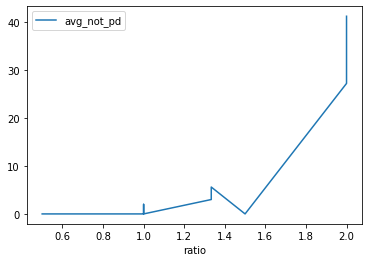

In [ ]:
p_npd.with_column(
    (pl.col('n_dim_state') / pl.col('n_dim_obs')
    ).alias("ratio")
).groupby(
    ['n_dim_obs', 'n_dim_state', 'n_dim_contr', 'ratio']
).agg(pl.col('n_err').mean().alias('avg_not_pd')
).sort('ratio'
).to_pandas().plot(x='ratio', y='avg_not_pd')


In [ ]:
%time pars_npd2 = find_params_not_posdef(4, [8,12,16], [4,8], 10)

CPU times: user 4min 52s, sys: 1.49 s, total: 4min 54s
Wall time: 3min 56s


In [ ]:
p_npd2 = pl.from_pandas(pars_npd2)

In [ ]:
p_npd2.groupby(['n_dim_obs', 'n_dim_state', 'n_dim_contr']).agg([pl.col('n_err').std().alias('std'), pl.col('n_err').mean().alias('mean')])

n_dim_obs,n_dim_state,n_dim_contr,std,mean
i64,i64,i64,f64,f64
4,8,4,0.0,0.0
4,16,4,0.0,0.0
4,12,4,0.0,0.0
4,8,8,0.0,0.0
4,16,8,0.0,0.0
4,12,8,0.0,0.0


<AxesSubplot: xlabel='ratio'>

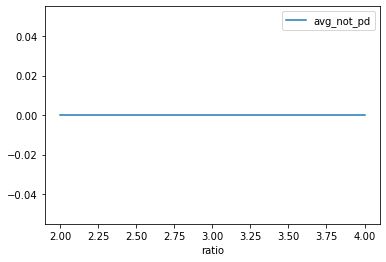

In [ ]:
p_npd2.with_column(
    (pl.col('n_dim_state') / pl.col('n_dim_obs')
    ).alias("ratio")
).groupby(
    ['n_dim_obs', 'n_dim_state', 'n_dim_contr', 'ratio']
).agg(pl.col('n_err').mean().alias('avg_not_pd')
).sort('ratio'
).to_pandas().plot(x='ratio', y='avg_not_pd')


In [ ]:
%time pars_npd3 = find_params_not_posdef([3,4,5], [6,8,10], 4, 10)

CPU times: user 8min 24s, sys: 2.02 s, total: 8min 26s
Wall time: 7min


In [ ]:
p_npd3 = pl.from_pandas(pars_npd3)

In [ ]:
p_npd3.groupby(
    ['n_dim_obs', 'n_dim_state', 'n_dim_contr']
    ).agg(
    [pl.col('n_err').std().alias('std'),
     pl.col('n_err').mean().alias('mean')]
    ).sort('n_dim_obs')

n_dim_obs,n_dim_state,n_dim_contr,std,mean
i64,i64,i64,f64,f64
3,6,4,31.291461,37.6
3,10,4,6.463573,96.0
3,8,4,9.150592,107.8
4,8,4,0.0,0.0
4,6,4,0.0,0.0
4,10,4,0.0,0.0
5,6,4,0.0,0.0
5,10,4,0.0,0.0
5,8,4,0.0,0.0


In [ ]:
ald.Chart(pars_npd).mark

In [ ]:
[ n_dims_obs + n_dim_state + n_dim_contr for n_dims_obs, n_dim_state, n_dim_contr in find_params_not_posdef([3], [3], [3,1])]

[9, 7]

In [ ]:
filter_posdef(n_dim_obs = 3,
              n_dim_state = 6,
              n_dim_contr = 6,
              n_obs = 200)

<meteo_imp.gaussian.CheckPosDef>

In [ ]:
filter_posdef(n_obs=100)

<meteo_imp.gaussian.CheckPosDef>

In [ ]:
filter_posdef(n_obs=500)

<meteo_imp.gaussian.CheckPosDef>

In [ ]:
filter_posdef(n_obs=500, gap_len=50)

<meteo_imp.gaussian.CheckPosDef>

In [ ]:
filter_posdef(n_obs=500, gap_len=50, n_dim_state=10)

<meteo_imp.gaussian.CheckPosDef>